
# EA FC Player Rating — Weight Optimization Report

This notebook documents and **runs** the pipeline that:
1) Loads players (from local cache `ea_fc_players.json` or EA's public ratings API),
2) Computes **optimized weights** per position (subject to non‑negative weights that sum to 1),
3) Evaluates error metrics and produces tables & charts,
4) Saves results to `optimizations.json` and a `weights.csv` for further analysis.

> **Tip:** If you're running this for the first time or on a clean environment, create a virtualenv and ensure you have `numpy`, `scipy`, `pandas`, and `matplotlib` installed.



## 0. Environment check

Imports and versions (useful for reproducibility).


In [24]:

import sys, platform, importlib
import numpy as np

def _maybe_version(modname):
    try:
        m = importlib.import_module(modname)
        return getattr(m, "__version__", "unknown")
    except Exception:
        return "not installed"

print("Python:", sys.version.split()[0], "|", platform.platform())
print("numpy:", _maybe_version("numpy"))
print("scipy:", _maybe_version("scipy"))
print("pandas:", _maybe_version("pandas"))
print("matplotlib:", _maybe_version("matplotlib"))


Python: 3.8.3 | Windows-10-10.0.26100-SP0
numpy: 1.24.4
scipy: 1.10.1
pandas: 2.0.3
matplotlib: 3.7.5



## 1. Project imports

We re‑use your existing modules:

- `shared_types.py` — TypedDicts and literals for players, positions, etc.
- `database.py` — Functions to fetch/cache players (`request_players_from_database`).
- `optimization.py` — Core routine `find_optimized_weights` (SciPy‑based).

> If these modules are not in the same directory as this notebook, update `sys.path` below.


In [25]:

from __future__ import annotations

import os
import json
from typing import List, Dict

# If your modules are not in the same folder, append their path:
# import sys
# sys.path.append(r"C:\path\to\your\modules")

from shared_types import (
    Player,
    ALL_POSITIONS_SHORT_LABELS,
    Optimization,
    PlayerStatisticName,
)

from database import request_players_from_database
from optimization import find_optimized_weights

PLAYERS_JSON_FILENAME = "ea_fc_players.json"



## 2. Load players

This cell tries to load from the local JSON cache first (`ea_fc_players.json`).  
If the file does not exist, it calls the API (via `request_players_from_database`) and creates the cache.


In [26]:

from pathlib import Path

players: List[Player] = []

if Path(PLAYERS_JSON_FILENAME).exists():
    with open(PLAYERS_JSON_FILENAME, encoding="utf-8") as f:
        data = json.load(f)
        if isinstance(data, dict) and "items" in data:
            players = data["items"]
        elif isinstance(data, list):
            # Allow a raw list too
            players = data
        else:
            raise RuntimeError("Unexpected schema in ea_fc_players.json")
else:
    # Will cache to the same filename as configured in your database module
    players = request_players_from_database()

len(players)


5486


### Quick peek


In [27]:

# Show a tiny sample (structure sanity-check)
import itertools
sample = list(itertools.islice(players, 3))
sample


[{'id': 231747,
  'rank': 1,
  'overallRating': 91,
  'firstName': 'Kylian',
  'lastName': 'Mbappé',
  'commonName': None,
  'birthdate': '12/20/1998 12:00:00 AM',
  'height': 182,
  'skillMoves': 5,
  'weakFootAbility': 4,
  'preferredFoot': 1,
  'leagueName': 'LALIGA EA SPORTS',
  'weight': 75,
  'avatarUrl': 'https://ratings-images-prod.pulse.ea.com/FC25/full/player-portraits/p231747.png?padding=0.7',
  'shieldUrl': 'https://ratings-images-prod.pulse.ea.com/FC25/full/player-shields/en/231747.png?width=265',
  'alternatePositions': [{'id': '27',
    'label': 'Left Wing',
    'shortLabel': 'LW'}],
  'playerAbilities': [{'id': 'trait1_1',
    'label': 'Finesse Shot',
    'description': 'Faster finesse shots with more curve and accuracy',
    'imageUrl': 'https://drop-assets.ea.com/images/468u1R1p2k1fA6WBHi0OEn/fb9d49ed2a8fb500cd5a184937b96b34/Finesse_Shot.png',
    'type': {'id': 'playStyle', 'label': 'Play Style'}},
   {'id': 'trait1_131072',
    'label': 'Rapid',
    'description': '


## 3. Basic stats per position


In [28]:

from collections import Counter

pos_counts = Counter([p["position"]["shortLabel"] for p in players])
sorted(pos_counts.items())


[('CAM', 346),
 ('CB', 1028),
 ('CDM', 509),
 ('CM', 628),
 ('GK', 525),
 ('LB', 373),
 ('LM', 350),
 ('LW', 129),
 ('RB', 411),
 ('RM', 322),
 ('RW', 123),
 ('ST', 742)]


## 4. Run the optimizations

- For **GK**, vary goalkeeper stats (`gkDiving`, `gkHandling`, `gkKicking`, `gkPositioning`, `gkReflexes`).
- For **outfield** positions, vary the 6 face‑card attributes (`pac`, `sho`, `pas`, `dri`, `def`, `phy`).

Target is the player's `overallRating`. Objective is **mean absolute relative error**.


In [29]:

optimizations: List[Optimization] = []

for position_short_label in ALL_POSITIONS_SHORT_LABELS:
    if position_short_label == "GK":
        varying_stat_names: List[PlayerStatisticName] = [
            "gkDiving",
            "gkHandling",
            "gkKicking",
            "gkPositioning",
            "gkReflexes",
        ]
    else:
        varying_stat_names = ["pac", "sho", "pas", "dri", "def", "phy"]

    opt = find_optimized_weights(
        optimization_name=f"{position_short_label} - Overall Rating",
        players=players,
        position_short_label=position_short_label,
        varying_stats_names=varying_stat_names,
        target_stat_name="overallRating",
    )
    optimizations.append(opt)

len(optimizations), optimizations[0]["name"]


Position: GK
Number of players: 525


Optimization completed. Mean relative error: 0.0069
Optimized weights: {'gkDiving': 0.24819137941384348, 'gkHandling': 0.16950558960550594, 'gkKicking': 0.03654154601922742, 'gkPositioning': 0.2230915751051761, 'gkReflexes': 0.32266990985624716}

Sample predictions (first 10 players):
  Player 1: Actual=89.0, Predicted=87.7, Error=1.47%
  Player 2: Actual=89.0, Predicted=87.7, Error=1.51%
  Player 3: Actual=89.0, Predicted=87.6, Error=1.54%
  Player 4: Actual=89.0, Predicted=87.6, Error=1.63%
  Player 5: Actual=88.0, Predicted=86.1, Error=2.19%
  Player 6: Actual=88.0, Predicted=86.5, Error=1.75%
  Player 7: Actual=88.0, Predicted=87.0, Error=1.18%
  Player 8: Actual=87.0, Predicted=85.2, Error=2.12%
  Player 9: Actual=87.0, Predicted=84.9, Error=2.37%
  Player 10: Actual=87.0, Predicted=85.8, Error=1.32%
--------------------------------------------------
Position: CB
Number of players: 1028




c:\software\FIFA Players Rating\.venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
c:\software\FIFA Players Rating\.venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimization completed. Mean relative error: 0.0075
Optimized weights: {'pac': 0.015808367375872868, 'sho': 4.8257592648582664e-18, 'pas': 0.018796245378391384, 'dri': 0.014132072095647827, 'def': 0.7766390234820612, 'phy': 0.17462429166802684}

Sample predictions (first 10 players):
  Player 1: Actual=89.0, Predicted=87.7, Error=1.45%
  Player 2: Actual=88.0, Predicted=87.7, Error=0.38%
  Player 3: Actual=88.0, Predicted=85.5, Error=2.88%
  Player 4: Actual=87.0, Predicted=85.7, Error=1.47%
  Player 5: Actual=87.0, Predicted=87.0, Error=0.03%
  Player 6: Actual=87.0, Predicted=85.7, Error=1.46%
  Player 7: Actual=86.0, Predicted=84.2, Error=2.04%
  Player 8: Actual=86.0, Predicted=84.6, Error=1.64%
  Player 9: Actual=86.0, Predicted=85.0, Error=1.22%
  Player 10: Actual=85.0, Predicted=83.4, Error=1.88%
--------------------------------------------------
Position: LB
Number of players: 373




c:\software\FIFA Players Rating\.venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimization completed. Mean relative error: 0.0248
Optimized weights: {'pac': 0.3034015197783084, 'sho': 0.0, 'pas': 7.012924583497253e-17, 'dri': 0.27184338114979734, 'def': 0.40225472286523684, 'phy': 0.022500376206657277}

Sample predictions (first 10 players):
  Player 1: Actual=87.0, Predicted=86.2, Error=0.87%
  Player 2: Actual=86.0, Predicted=81.5, Error=5.25%
  Player 3: Actual=85.0, Predicted=79.5, Error=6.50%
  Player 4: Actual=84.0, Predicted=80.0, Error=4.72%
  Player 5: Actual=84.0, Predicted=82.2, Error=2.19%
  Player 6: Actual=83.0, Predicted=78.8, Error=5.04%
  Player 7: Actual=83.0, Predicted=80.4, Error=3.10%
  Player 8: Actual=83.0, Predicted=82.4, Error=0.75%
  Player 9: Actual=82.0, Predicted=77.6, Error=5.38%
  Player 10: Actual=82.0, Predicted=82.3, Error=0.40%
--------------------------------------------------
Position: RB
Number of players: 411




c:\software\FIFA Players Rating\.venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimization completed. Mean relative error: 0.0253
Optimized weights: {'pac': 0.32200946909588546, 'sho': 4.982472009360942e-17, 'pas': 6.15369114214822e-18, 'dri': 0.12276257266572736, 'def': 0.546756942124066, 'phy': 0.008471016114321031}

Sample predictions (first 10 players):
  Player 1: Actual=86.0, Predicted=81.0, Error=5.83%
  Player 2: Actual=86.0, Predicted=78.3, Error=8.91%
  Player 3: Actual=86.0, Predicted=77.5, Error=9.92%
  Player 4: Actual=85.0, Predicted=84.0, Error=1.23%
  Player 5: Actual=84.0, Predicted=80.8, Error=3.82%
  Player 6: Actual=84.0, Predicted=82.1, Error=2.24%
  Player 7: Actual=84.0, Predicted=79.1, Error=5.78%
  Player 8: Actual=83.0, Predicted=79.6, Error=4.04%
  Player 9: Actual=83.0, Predicted=76.0, Error=8.38%
  Player 10: Actual=82.0, Predicted=81.1, Error=1.15%
--------------------------------------------------
Position: CDM
Number of players: 509


Optimization completed. Mean relative error: 0.0277
Optimized weights: {'pac': 2.4728245151450775

c:\software\FIFA Players Rating\.venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
c:\software\FIFA Players Rating\.venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimization completed. Mean relative error: 0.0167
Optimized weights: {'pac': 1.5757403130265134e-17, 'sho': 3.4032600935251862e-18, 'pas': 0.3576729695223546, 'dri': 0.5257621590346796, 'def': 0.017745121899354458, 'phy': 0.09881974954361127}

Sample predictions (first 10 players):
  Player 1: Actual=90.0, Predicted=88.2, Error=1.97%
  Player 2: Actual=89.0, Predicted=86.3, Error=2.99%
  Player 3: Actual=88.0, Predicted=83.9, Error=4.63%
  Player 4: Actual=88.0, Predicted=87.2, Error=0.90%
  Player 5: Actual=87.0, Predicted=85.6, Error=1.64%
  Player 6: Actual=87.0, Predicted=84.7, Error=2.68%
  Player 7: Actual=87.0, Predicted=84.4, Error=2.96%
  Player 8: Actual=86.0, Predicted=84.8, Error=1.39%
  Player 9: Actual=86.0, Predicted=83.4, Error=2.99%
  Player 10: Actual=86.0, Predicted=84.2, Error=2.15%
--------------------------------------------------
Position: CAM
Number of players: 346




c:\software\FIFA Players Rating\.venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimization completed. Mean relative error: 0.0115
Optimized weights: {'pac': 0.045162158904686556, 'sho': 0.15620738896157518, 'pas': 0.2676668503650734, 'dri': 0.5234237846085422, 'def': 1.26680979239526e-20, 'phy': 0.007539817160122546}

Sample predictions (first 10 players):
  Player 1: Actual=90.0, Predicted=86.1, Error=4.33%
  Player 2: Actual=88.0, Predicted=86.2, Error=2.02%
  Player 3: Actual=87.0, Predicted=84.9, Error=2.40%
  Player 4: Actual=87.0, Predicted=86.4, Error=0.63%
  Player 5: Actual=87.0, Predicted=84.0, Error=3.44%
  Player 6: Actual=85.0, Predicted=83.8, Error=1.36%
  Player 7: Actual=85.0, Predicted=84.4, Error=0.74%
  Player 8: Actual=84.0, Predicted=83.5, Error=0.58%
  Player 9: Actual=84.0, Predicted=83.2, Error=0.90%
  Player 10: Actual=83.0, Predicted=82.3, Error=0.89%
--------------------------------------------------
Position: LW
Number of players: 129




c:\software\FIFA Players Rating\.venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimization completed. Mean relative error: 0.0086
Optimized weights: {'pac': 0.12440184450493197, 'sho': 0.22605769099829384, 'pas': 0.21812845138117135, 'dri': 0.42632983222233417, 'def': 6.6237976475286294e-18, 'phy': 0.005082180893268775}

Sample predictions (first 10 players):
  Player 1: Actual=90.0, Predicted=87.6, Error=2.64%
  Player 2: Actual=87.0, Predicted=86.3, Error=0.82%
  Player 3: Actual=86.0, Predicted=84.5, Error=1.76%
  Player 4: Actual=85.0, Predicted=83.0, Error=2.31%
  Player 5: Actual=84.0, Predicted=83.1, Error=1.06%
  Player 6: Actual=84.0, Predicted=82.4, Error=1.89%
  Player 7: Actual=83.0, Predicted=83.3, Error=0.35%
  Player 8: Actual=83.0, Predicted=81.7, Error=1.60%
  Player 9: Actual=83.0, Predicted=82.7, Error=0.34%
  Player 10: Actual=83.0, Predicted=82.5, Error=0.59%
--------------------------------------------------
Position: LM
Number of players: 350




c:\software\FIFA Players Rating\.venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
c:\software\FIFA Players Rating\.venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimization completed. Mean relative error: 0.0108
Optimized weights: {'pac': 0.1414759785678951, 'sho': 0.041151026087929345, 'pas': 0.3441262179952892, 'dri': 0.4511996549179421, 'def': 4.8906421552208865e-18, 'phy': 0.022047122430944366}

Sample predictions (first 10 players):
  Player 1: Actual=86.0, Predicted=83.7, Error=2.71%
  Player 2: Actual=85.0, Predicted=83.3, Error=1.97%
  Player 3: Actual=84.0, Predicted=83.5, Error=0.61%
  Player 4: Actual=84.0, Predicted=82.4, Error=1.94%
  Player 5: Actual=83.0, Predicted=79.8, Error=3.83%
  Player 6: Actual=82.0, Predicted=80.6, Error=1.67%
  Player 7: Actual=82.0, Predicted=81.3, Error=0.81%
  Player 8: Actual=82.0, Predicted=82.1, Error=0.14%
  Player 9: Actual=81.0, Predicted=79.9, Error=1.40%
  Player 10: Actual=81.0, Predicted=80.5, Error=0.57%
--------------------------------------------------
Position: RW
Number of players: 123


Optimization completed. Mean relative error: 0.0091
Optimized weights: {'pac': 0.1121894683834186,

c:\software\FIFA Players Rating\.venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
c:\software\FIFA Players Rating\.venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimization completed. Mean relative error: 0.0130
Optimized weights: {'pac': 0.05550061473110265, 'sho': 0.7346177935267352, 'pas': 0.0, 'dri': 0.1178597748574321, 'def': 6.288372600415924e-18, 'phy': 0.09202181688473007}

Sample predictions (first 10 players):
  Player 1: Actual=91.0, Predicted=89.5, Error=1.63%
  Player 2: Actual=91.0, Predicted=90.1, Error=0.97%
  Player 3: Actual=90.0, Predicted=89.3, Error=0.83%
  Player 4: Actual=89.0, Predicted=87.3, Error=1.94%
  Player 5: Actual=88.0, Predicted=86.5, Error=1.73%
  Player 6: Actual=88.0, Predicted=86.7, Error=1.51%
  Player 7: Actual=87.0, Predicted=83.7, Error=3.75%
  Player 8: Actual=87.0, Predicted=86.9, Error=0.06%
  Player 9: Actual=86.0, Predicted=85.4, Error=0.66%
  Player 10: Actual=86.0, Predicted=83.7, Error=2.67%
--------------------------------------------------


(12, 'GK - Overall Rating')


## 5. Tabulate results

We'll expand weights into columns, add the `mean_error`, and sort for quick comparison.


In [30]:

import pandas as pd

rows = []
for opt in optimizations:
    row = {
        "position": opt["position_short_label"],
        "name": opt["name"],
        "target": opt["target_stat_name"],
        "mean_error": opt["mean_error"],
    }
    # Expand weights into columns
    for stat, w in opt["optimized_weights"].items():
        row[f"w_{stat}"] = w
    rows.append(row)

df = pd.DataFrame(rows)
df = df.sort_values(["position"]).reset_index(drop=True)
df


,position,name,target,mean_error,w_gkDiving,w_gkHandling,w_gkKicking,w_gkPositioning,w_gkReflexes,w_pac,w_sho,w_pas,w_dri,w_def,w_phy
0,CAM,CAM - Overall Rating,overallRating,0.011478,NaN,NaN,NaN,NaN,NaN,4.516216e-02,1.562074e-01,2.676669e-01,0.523424,1.266810e-20,0.007540
1,CB,CB - Overall Rating,overallRating,0.007514,NaN,NaN,NaN,NaN,NaN,1.580837e-02,4.825759e-18,1.879625e-02,0.014132,7.766390e-01,0.174624
2,CDM,CDM - Overall Rating,overallRating,0.027734,NaN,NaN,NaN,NaN,NaN,2.472825e-17,0.000000e+00,6.819613e-17,0.316276,3.121095e-01,0.371614
3,CM,CM - Overall Rating,overallRating,0.016676,NaN,NaN,NaN,NaN,NaN,1.575740e-17,3.403260e-18,3.576730e-01,0.525762,1.774512e-02,0.098820
4,GK,GK - Overall Rating,overallRating,0.006879,0.248191,0.169506,0.036542,0.223092,0.32267,NaN,NaN,NaN,NaN,NaN,NaN
5,LB,LB - Overall Rating,overallRating,0.024847,NaN,NaN,NaN,NaN,NaN,3.034015e-01,0.000000e+00,7.012925e-17,0.271843,4.022547e-01,0.022500
6,LM,LM - Overall Rating,overallRating,0.010813,NaN,NaN,NaN,NaN,NaN,1.414760e-01,4.115103e-02,3.441262e-01,0.451200,4.890642e-18,0.022047
7,LW,LW - Overall Rating,overallRating,0.008583,NaN,NaN,NaN,NaN,NaN,1.244018e-01,2.260577e-01,2.181285e-01,0.426330,6.623798e-18,0.005082
8,RB,RB - Overall Rating,overallRating,0.025276,NaN,NaN,NaN,NaN,NaN,3.220095e-01,4.982472e-17,6.153691e-18,0.122763,5.467569e-01,0.008471
9,RM,RM - Overall Rating,overallRating,0.011760,NaN,NaN,NaN,NaN,NaN,1.478353e-01,4.291117e-02,2.848929e-01,0.479561,1.536529e-18,0.044800



### Sorted by mean error (ascending)


In [31]:

df_sorted = df.sort_values("mean_error").reset_index(drop=True)
df_sorted


,position,name,target,mean_error,w_gkDiving,w_gkHandling,w_gkKicking,w_gkPositioning,w_gkReflexes,w_pac,w_sho,w_pas,w_dri,w_def,w_phy
0,GK,GK - Overall Rating,overallRating,0.006879,0.248191,0.169506,0.036542,0.223092,0.32267,NaN,NaN,NaN,NaN,NaN,NaN
1,CB,CB - Overall Rating,overallRating,0.007514,NaN,NaN,NaN,NaN,NaN,1.580837e-02,4.825759e-18,1.879625e-02,0.014132,7.766390e-01,0.174624
2,LW,LW - Overall Rating,overallRating,0.008583,NaN,NaN,NaN,NaN,NaN,1.244018e-01,2.260577e-01,2.181285e-01,0.426330,6.623798e-18,0.005082
3,RW,RW - Overall Rating,overallRating,0.009147,NaN,NaN,NaN,NaN,NaN,1.121895e-01,2.133816e-01,1.905096e-01,0.470097,1.078608e-18,0.013822
4,LM,LM - Overall Rating,overallRating,0.010813,NaN,NaN,NaN,NaN,NaN,1.414760e-01,4.115103e-02,3.441262e-01,0.451200,4.890642e-18,0.022047
5,CAM,CAM - Overall Rating,overallRating,0.011478,NaN,NaN,NaN,NaN,NaN,4.516216e-02,1.562074e-01,2.676669e-01,0.523424,1.266810e-20,0.007540
6,RM,RM - Overall Rating,overallRating,0.011760,NaN,NaN,NaN,NaN,NaN,1.478353e-01,4.291117e-02,2.848929e-01,0.479561,1.536529e-18,0.044800
7,ST,ST - Overall Rating,overallRating,0.013041,NaN,NaN,NaN,NaN,NaN,5.550061e-02,7.346178e-01,0.000000e+00,0.117860,6.288373e-18,0.092022
8,CM,CM - Overall Rating,overallRating,0.016676,NaN,NaN,NaN,NaN,NaN,1.575740e-17,3.403260e-18,3.576730e-01,0.525762,1.774512e-02,0.098820
9,LB,LB - Overall Rating,overallRating,0.024847,NaN,NaN,NaN,NaN,NaN,3.034015e-01,0.000000e+00,7.012925e-17,0.271843,4.022547e-01,0.022500



## 6. Visualize weights per position

Simple bar charts for each position.


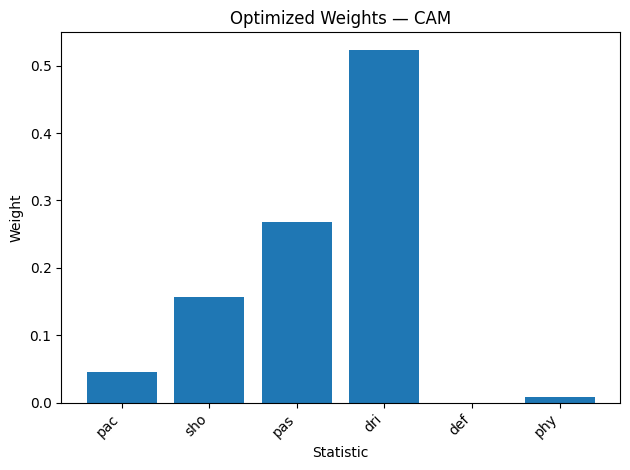

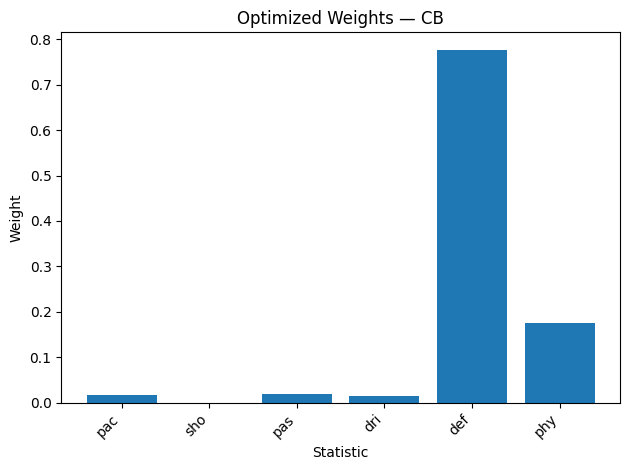

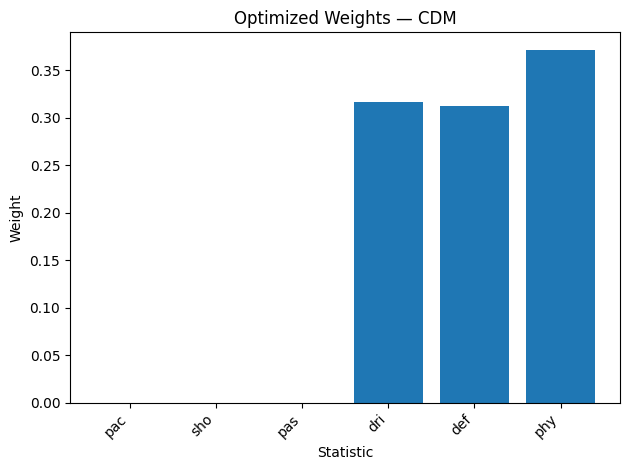

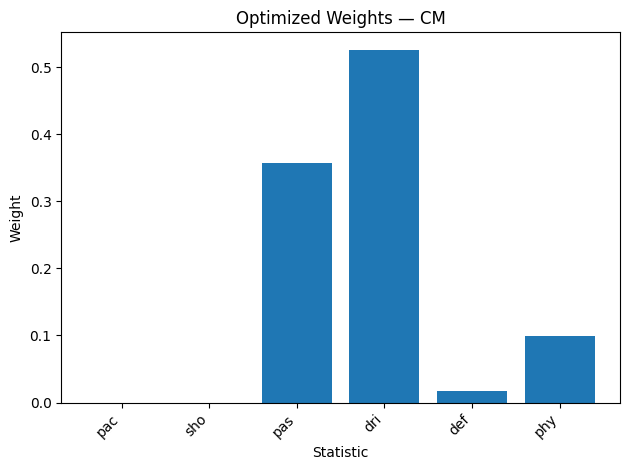

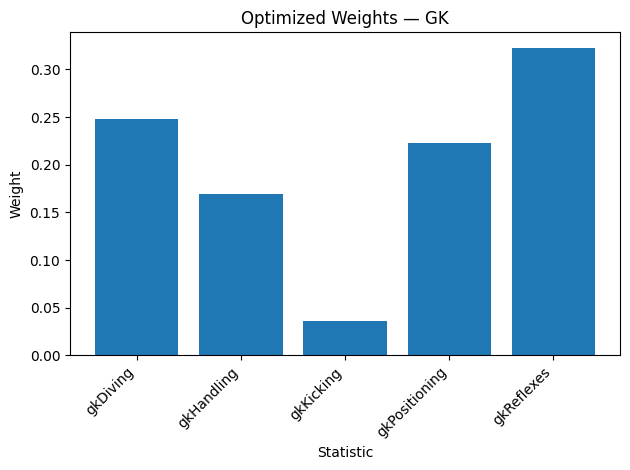

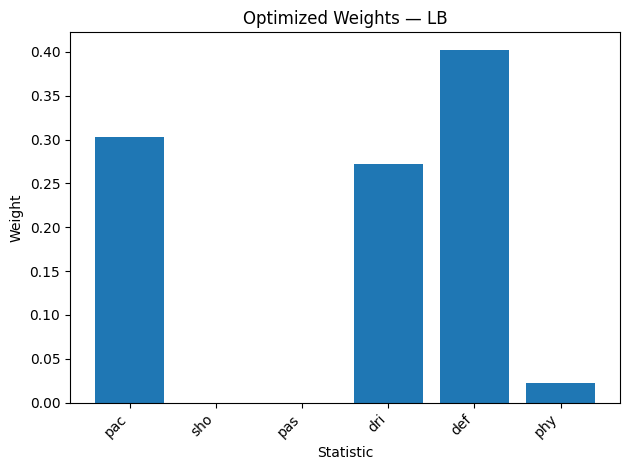

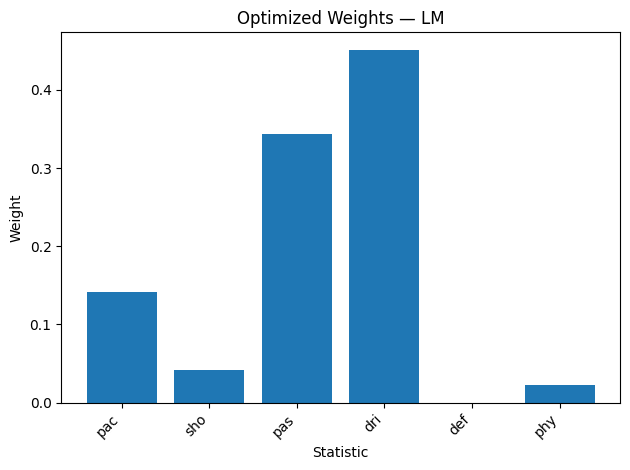

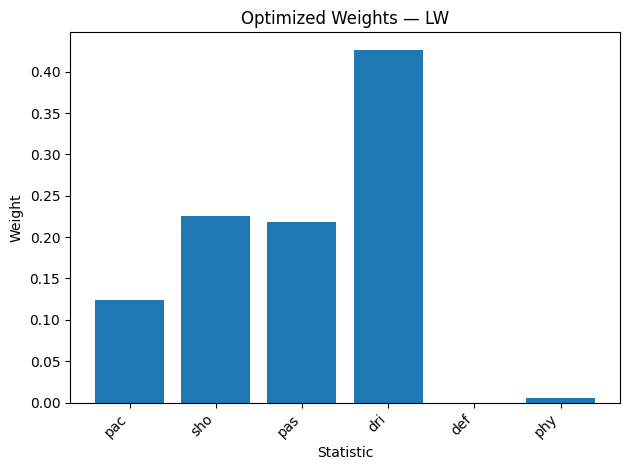

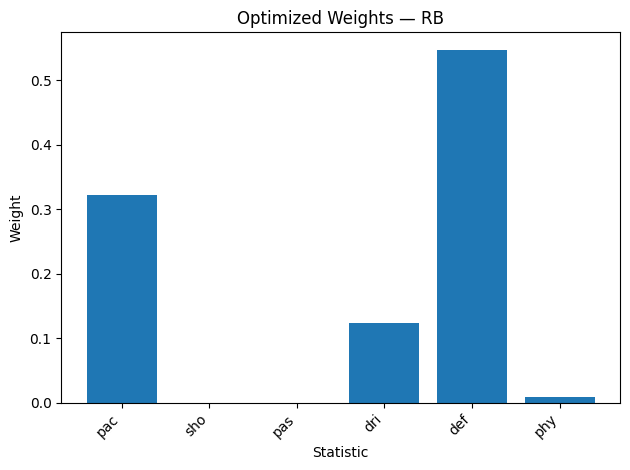

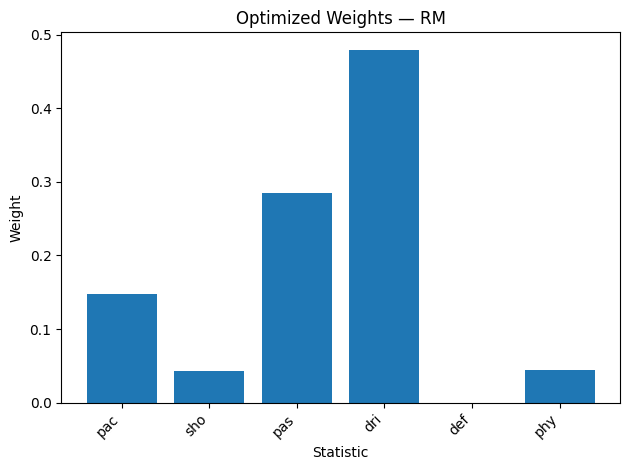

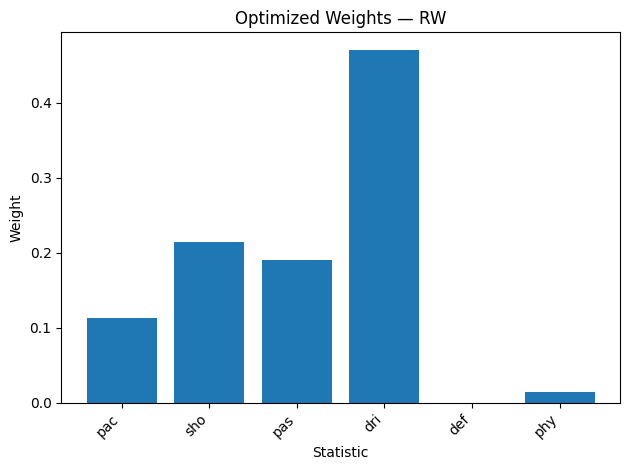

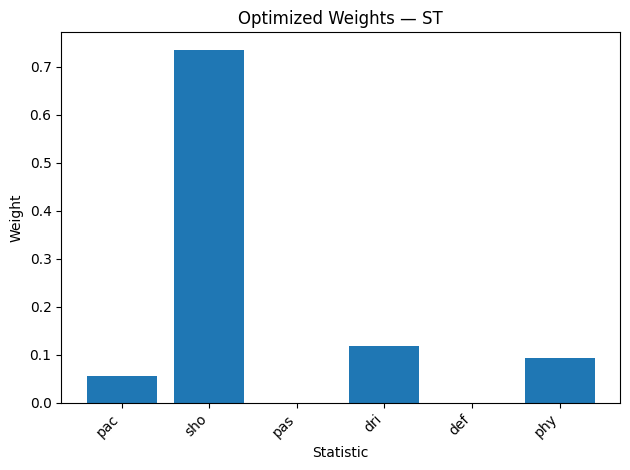

In [32]:

import matplotlib.pyplot as plt

for _, row in df.iterrows():
    position = row["position"]
    # Pick only columns that start with 'w_'
    weight_cols = [c for c in df.columns if c.startswith("w_")]
    stats = [c.replace("w_", "") for c in weight_cols if not pd.isna(row[c])]
    weights = [row[c] for c in weight_cols if not pd.isna(row[c])]

    if not stats:
        continue

    plt.figure()
    plt.bar(stats, weights)
    plt.title(f"Optimized Weights — {position}")
    plt.xlabel("Statistic")
    plt.ylabel("Weight")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



## 7. Save outputs

- `optimizations.json`: full structured output per position  
- `weights.csv`: flat table handy for spreadsheets


In [33]:

with open("optimizations.json", "w", encoding="utf-8") as f:
    json.dump(optimizations, f, ensure_ascii=False, indent=2)

df.to_csv("weights.csv", index=False, encoding="utf-8")
print("Saved: optimizations.json and weights.csv")


Saved: optimizations.json and weights.csv



## 8. (Optional) Error distribution sanity check

We recompute predictions with the learned weights for one position to see the error distribution.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _players_by_position(players, pos):
    return [p for p in players if p["position"]["shortLabel"] == pos]

def _errors_for_position(players, opt):
    pos = opt["position_short_label"]
    players_pos = _players_by_position(players, pos)

    vary = list(opt["optimized_weights"].keys())
    if len(vary) == 0 or len(players_pos) == 0:
        return pos, np.array([])

    w = np.array([opt["optimized_weights"][k] for k in vary], dtype=float)

    y_actual = []
    y_pred = []
    target = opt["target_stat_name"]

    for p in players_pos:
        if target == "overallRating":
            ya = float(p["overallRating"])
        else:
            ya = float(p["stats"][target]["value"])

        # build feature vector
        x = np.array([float(p["stats"][k]["value"]) for k in vary], dtype=float)
        yp = float(w @ x)
        if ya != 0:
            y_actual.append(ya)
            y_pred.append(yp)

    if not y_actual:
        return pos, np.array([])

    y_actual = np.array(y_actual, dtype=float)
    y_pred   = np.array(y_pred, dtype=float)
    rel_err  = np.abs((y_pred - y_actual) / y_actual)
    return pos, rel_err

# --- Compute error arrays for every position we have optimization for
rel_err_by_pos: dict[str, np.ndarray] = {}
for opt in optimizations:
    pos, rel_err = _errors_for_position(players, opt)
    rel_err_by_pos[pos] = rel_err

# --- Summary table
summary_rows = []
for pos, arr in rel_err_by_pos.items():
    if arr.size == 0:
        summary_rows.append({
            "position": pos,
            "n_samples": 0,
            "mean_err": np.nan,
            "median_err": np.nan,
            "p95_err": np.nan,
            "max_err": np.nan,
        })
    else:
        summary_rows.append({
            "position": pos,
            "n_samples": int(arr.size),
            "mean_err": float(np.mean(arr)),
            "median_err": float(np.median(arr)),
            "p95_err": float(np.percentile(arr, 95)),
            "max_err": float(np.max(arr)),
        })



In [36]:
summary_df

,position,n_samples,mean_err,median_err,p95_err,max_err
0,GK,525,0.006879,0.005484,0.018478,0.034939
1,CB,1028,0.007514,0.006049,0.019285,0.034952
2,LW,129,0.008583,0.006943,0.022655,0.034350
3,RW,123,0.009147,0.007577,0.022749,0.035904
4,LM,350,0.010813,0.008457,0.026650,0.053634
5,CAM,346,0.011478,0.008617,0.028748,0.058344
6,RM,322,0.011760,0.009842,0.028981,0.048701
7,ST,742,0.013041,0.011329,0.031888,0.061854
8,CM,628,0.016676,0.013091,0.044602,0.090969
9,LB,373,0.024847,0.021858,0.059984,0.086977


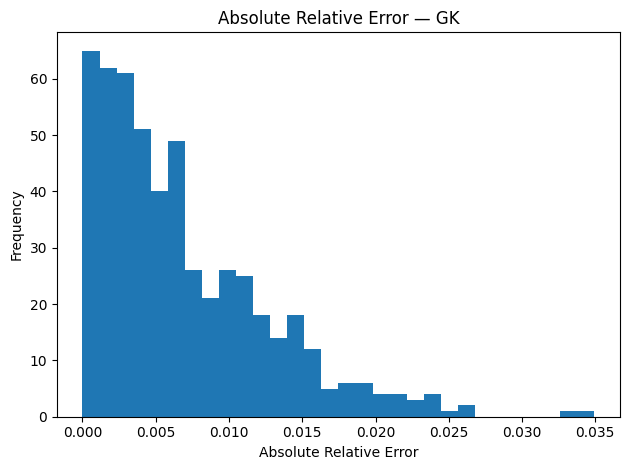

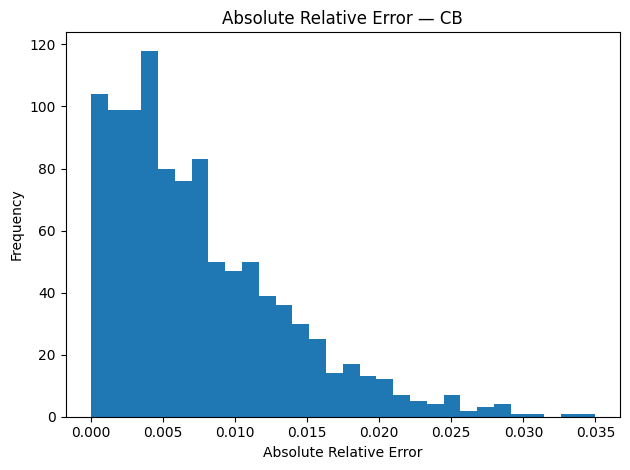

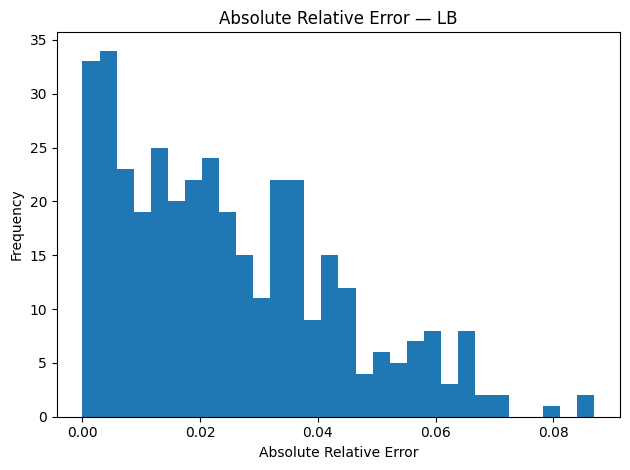

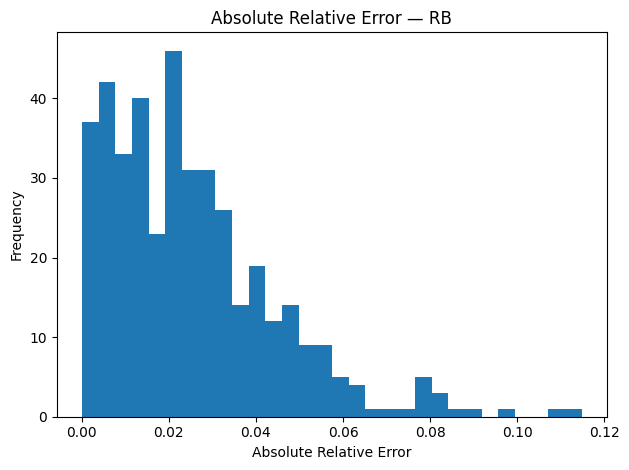

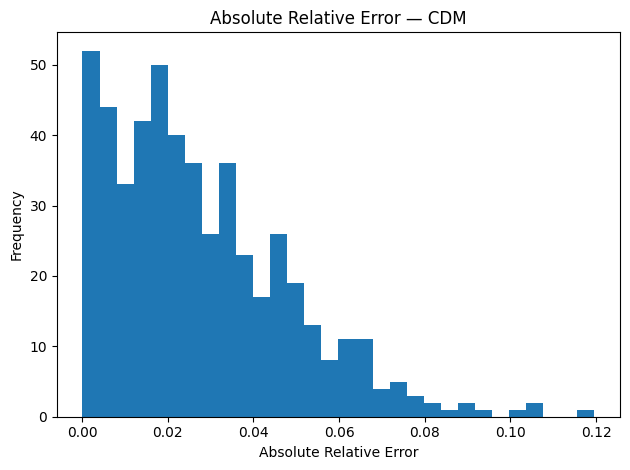

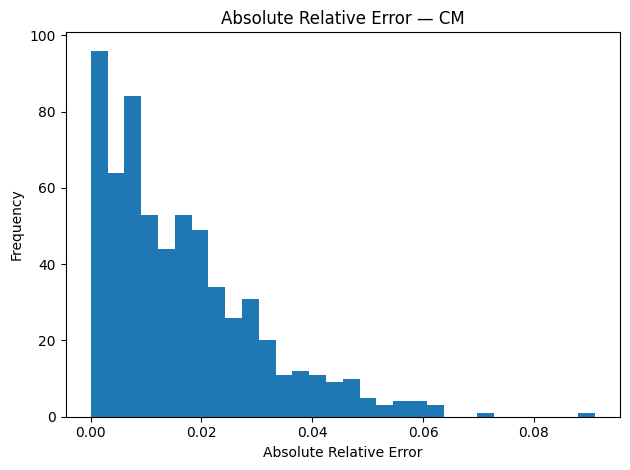

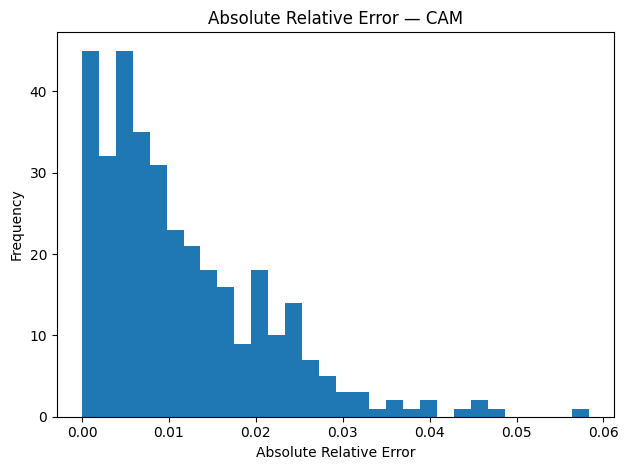

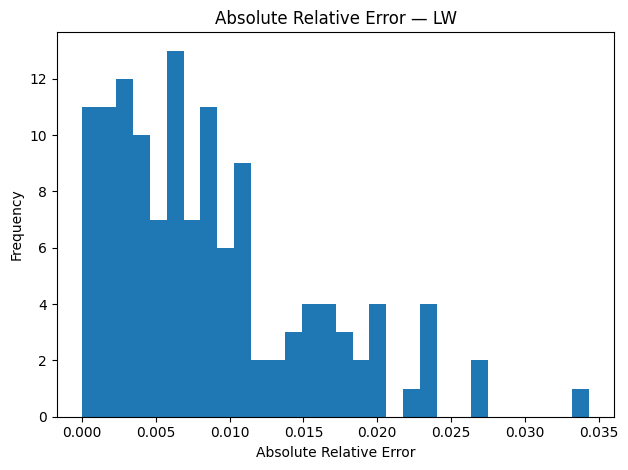

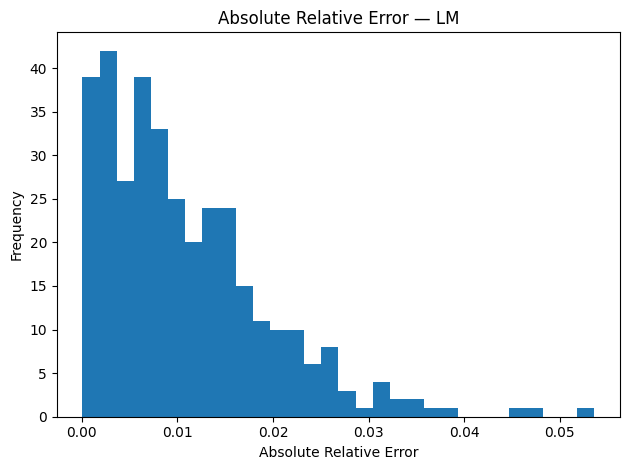

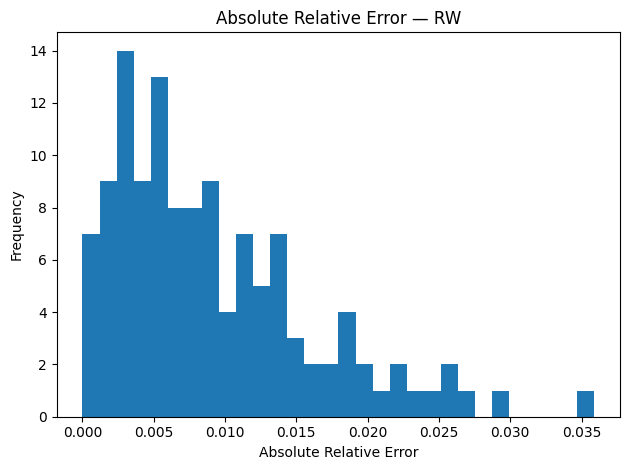

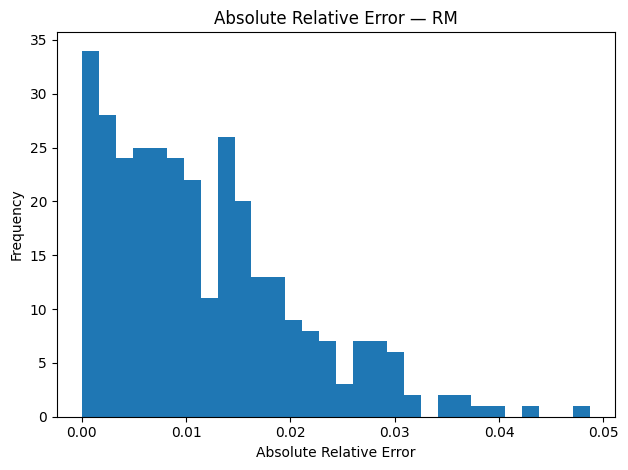

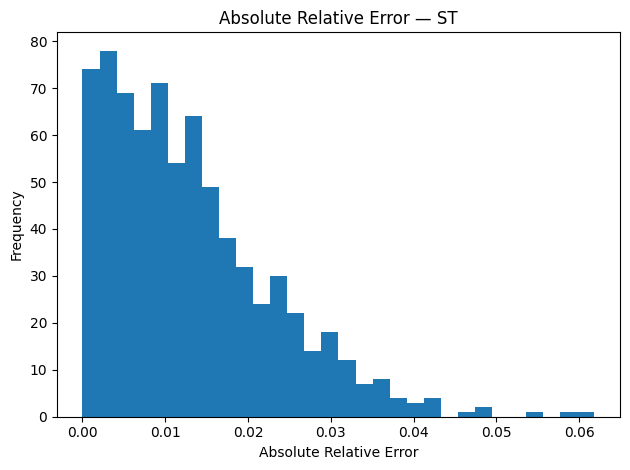

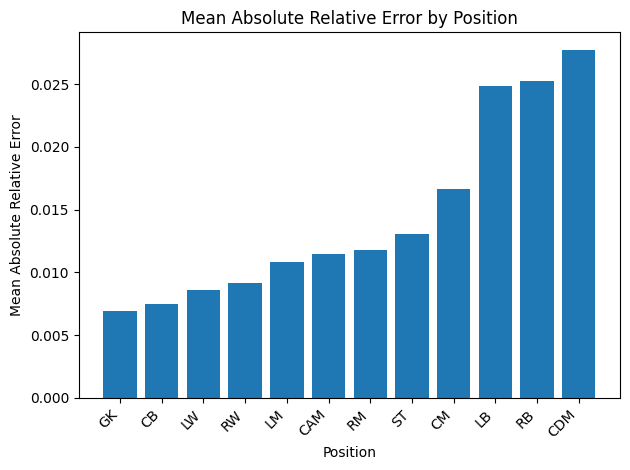

In [37]:
# One histogram per position
for pos, arr in rel_err_by_pos.items():
    if arr.size == 0:
        continue
    plt.figure()
    plt.hist(arr, bins=30)
    plt.title(f"Absolute Relative Error — {pos}")
    plt.xlabel("Absolute Relative Error")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Bar chart of mean errors per position
means = summary_df.dropna(subset=["mean_err"])
plt.figure()
plt.bar(means["position"], means["mean_err"])
plt.title("Mean Absolute Relative Error by Position")
plt.xlabel("Position")
plt.ylabel("Mean Absolute Relative Error")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


---

### Notes & Assumptions

- This uses a **constrained optimization** (non‑negative weights summing to 1), solved with `scipy.optimize.minimize` (SLSQP / trust‑constr).
- Target is the (public) `overallRating`. The model is a **simple weighted average** of the chosen sub‑stats.
- **Data hygiene**: players with `overallRating == 0` are excluded for error computation to avoid division by zero.
- If the API is throttled or temporarily unavailable, the loader will cache progress page by page into `ea_fc_players.json`.

Feel free to extend this notebook with cross‑validation, k‑folds per position, or more sophisticated error metrics.
